# Anastomotic Leakage Prediction
### Phase 1 - Statistical Analysis

Taking the existing data manipulation and investigating:
#### 1.1.
* WRS, p value on the leakage vs not leakage for each existing attributes
* Drop patients with missing value for the specific attribute in wrs

#### 1.2.
* If patients have no event data and have 0 on target, remove them

#### 1.3.
* Add categorical data and analyze correlation to target via hypergeometric

#### 1.4.
* Clear data by outlier detection. Look at the stf if its past 3std from the mean on both sides


In [39]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from datetime import datetime
from datetime import date 
from scipy import stats
import statsmodels.stats as ss 

import warnings
warnings.filterwarnings("ignore")


In [40]:
COMBINED_DATA_FILE = '../data_files/matrix0_missing_values.xlsx'
# EVENTS = '../data_files/data1.csv'
PATIENTS = '../data_files/anonymous_080620_DA_eg.xlsx' # Patient surgery data

full_df = pd.read_excel(COMBINED_DATA_FILE, header=[0,1,2,3])[1:]
# events_df = pd.read_csv(EVENTS)
patients_df = pd.read_excel(PATIENTS)

In [41]:
full_df

type metadata                                       \
           time  general                                        
        feature      Sex      Age   Urgency Surgical approach   
      statistic constant constant  constant          constant   
1       1123813     male     59.0  elective              Open   
2       1135541   female     43.0  elective              Open   
3       3918745   female     57.0  elective      Laparoscopic   
4       4894647      NaN      NaN  elective              Open   
5       6541482   female     65.0    urgent              Open   
..          ...      ...      ...       ...               ...   
521  1031926105   female     63.0  elective              Open   
522  1032366104   female     63.0  elective              Open   
523  1033842103     male     61.0  elective              Open   
524  1034462102     male     76.0  elective              Open   
525  1035830101   female     65.0  elective              Open   

                     numeric_events                        ...                \
                     before_surgery                        ... after_surgery   
    Anastomotic Leak        Albumin                        ...       weight    
            constant            max      mean median  min  ...          mean   
1                1.0            4.2  4.200000   4.20  4.2  ...     96.966667   
2                0.0            NaN       NaN    NaN  NaN  ...     68.000000   
3                0.0            3.9  3.900000   3.90  3.9  ...           NaN   
4                0.0            4.3  4.300000   4.30  4.3  ...     71.125000   
5                0.0            3.1  1.942857   1.95  1.4  ...     54.666667   
..               ...            ...       ...    ...  ...  ...           ...   
521              0.0            NaN       NaN    NaN  NaN  ...           NaN   
522              0.0            4.1  4.100000   4.10  4.1  ...     50.500000   
523              1.0            4.8  4.800000   4.80  4.8  ...           NaN   
524              0.0            4.3  4.300000   4.30  4.3  ...           NaN   
525              0.0            3.7  3.700000   3.70  3.7  ...           NaN   

                     drugs                                     \
                  all_days                                      
                 Cefazolin Ceftriaxone Fleet enema Furosemide   
    median   min     count       count       count      count   
1    105.0  85.3       6.0        13.0         1.0       16.0   
2     68.0  68.0       NaN        10.0         NaN        2.0   
3      NaN   NaN       NaN         NaN         NaN        NaN   
4     74.6   0.0       5.0        12.0         1.0       38.0   
5     53.0  53.0       4.0        15.0         NaN      151.0   
..     ...   ...       ...         ...         ...        ...   
521    NaN   NaN       2.0         NaN         1.0        NaN   
522   52.0  46.0       3.0         1.0         2.0        2.0   
523    NaN   NaN       4.0        27.0         1.0        8.0   
524    NaN   NaN       5.0         NaN         1.0        NaN   
525    NaN   NaN       1.0         NaN         1.0        NaN   

                                                 
                                                 
    Magnesium sulfate Meroken new Metronidazole  
                count       count         count  
1                 4.0         1.0          52.0  
2                 NaN         NaN          26.0  
3                 NaN         NaN           NaN  
4                 1.0         1.0          73.0  
5                 7.0         NaN          51.0  
..                ...         ...           ...  
521               NaN         1.0           2.0  
522              24.0         2.0           4.0  
523              13.0         1.0          62.0  
524               2.0         1.0           3.0  
525               1.0         1.0           1.0  

[525 rows x 481 columns]

### 1.1
#### Feature Statistical Significance
We will reconstruct the data to remove the large headers to it will be easier to manipulate and calculate the p_value of all features. 
We will maintain 3 dataframes:
1. patient_data
2. before_surgery_data
3. after_surgery_data

For dataframes with median, mean, max, min we will take the $mean$ value 


In [42]:
# Group One - Group of the patient and surgery attributes
group_one = full_df.iloc[:, 0:6]
group_one.columns = full_df.columns.get_level_values(2)[0:6]
# group_one

# Group Two - Group of the event attributes
group_two = full_df.iloc[:,6:-7]
group_two = group_two.iloc[:, 1::4]  # 4 = Taking the mean from each features
group_two.columns = group_two.columns.get_level_values(2)

In [43]:
# Concatenating the two lists (easier to do this because of hierarchical headers)
raw_data = pd.concat([group_one, group_two], axis=1, sort=False)

In [44]:
# This data set has all data with smaller header
raw_data.rename(columns={'feature': 'ID'}, inplace=True)
raw_data

ID     Sex   Age   Urgency Surgical approach  Anastomotic Leak  \
1       1123813    male  59.0  elective              Open               1.0   
2       1135541  female  43.0  elective              Open               0.0   
3       3918745  female  57.0  elective      Laparoscopic               0.0   
4       4894647     NaN   NaN  elective              Open               0.0   
5       6541482  female  65.0    urgent              Open               0.0   
..          ...     ...   ...       ...               ...               ...   
521  1031926105  female  63.0  elective              Open               0.0   
522  1032366104  female  63.0  elective              Open               0.0   
523  1033842103    male  61.0  elective              Open               1.0   
524  1034462102    male  76.0  elective              Open               0.0   
525  1035830101  female  65.0  elective              Open               0.0   

      Albumin  Alkaline Phosphatase    Amylase  BASO (%)  ...      WBC_1  \
1    4.200000                  97.0  63.000000  0.500000  ...   7.262093   
2         NaN                   NaN        NaN       NaN  ...  11.480556   
3    3.900000                  90.0  53.000000  0.400000  ...  11.616000   
4    4.300000                  70.0        NaN  0.300000  ...   5.549455   
5    1.942857                  94.0  32.692308  0.121429  ...  13.174151   
..        ...                   ...        ...       ...  ...        ...   
521       NaN                   NaN        NaN       NaN  ...   5.947778   
522  4.100000                 133.0  78.000000  0.600000  ...   4.561719   
523  4.800000                  89.0  19.000000  0.300000  ...   9.365849   
524  4.300000                  92.0  95.000000  0.500000  ...   5.274000   
525  3.700000                 101.0  40.000000  0.400000  ...   9.785455   

     blood pressure  blood pressure diastolic   blood pressure systolic  \
1         89.676093                  64.431373               120.596026   
2         90.180000                  51.000000                97.000000   
3        115.000000                  75.357143               126.851852   
4         89.430524                  63.564885               114.832000   
5         99.845560                  76.267176               128.078740   
..              ...                        ...                      ...   
521      106.214286                  67.270588               121.282353   
522      102.408163                  64.205357               119.700000   
523       98.692230                  71.186441               129.844828   
524      121.948276                  58.076923               118.947368   
525       94.272727                  64.230769               110.555556   

     body temperature  heart rate      height  respiratory rate, CO2  \
1           36.609656   87.566667  174.000000               9.800000   
2           36.745455   87.760000  170.000000               6.647059   
3           35.727778   73.147059         NaN               4.684211   
4           36.658712   86.694690  168.583333               6.585366   
5           36.910182   89.780980  150.000000               8.125000   
..                ...         ...         ...                    ...   
521         36.652381  100.649254         NaN               9.593750   
522         36.592308   87.720548  151.285714               5.288136   
523         37.121285   87.518519         NaN              11.107143   
524         36.175000   74.742424         NaN              11.916667   
525         36.853333   93.605839         NaN               8.758621   

     saturation    weight   
1     97.169284  96.966667  
2     97.927711  68.000000  
3     96.787879        NaN  
4     96.739583  71.125000  
5     97.231970  54.666667  
..          ...        ...  
521   97.245455        NaN  
522   97.741935  50.500000  
523   96.892694        NaN  
524   97.530303        NaN  
525   97.781818        NaN  

[525 rows x 123 columns]

In [45]:
patients_df = patients_df.drop_duplicates() # Removed ~150 duplicates

In [46]:
# Attempted to add surgery name/area but there is an issue with the dates of each surgery. 

# Taking only relevant columns
patient_extra_data = pd.concat([patients_df.iloc[:,0:1], patients_df.iloc[:,-10:-9], patients_df.iloc[:,-9:-7]], axis=1, sort=False)
# Taking only patients that have more than one surgery, 36 patients
duplicate_sugeries_patients = patient_extra_data['Code'].value_counts().to_frame().iloc[:36,:].reset_index()
# Look at the entire row for these patients with many surgeries
temp = patient_extra_data.merge(duplicate_sugeries_patients,right_on="index", left_on="Code", how='inner')
temp.iloc[:50,:-2]

Code_x Surgery Date Patient Classification  \
0    111570821   2018-06-07      Surgical Oncology   
1    111570821   2018-05-06      Surgical Oncology   
2    110558531   2018-06-02      Surgical Oncology   
3    110558531   2018-05-30      Surgical Oncology   
4    110558531   2018-12-10             Colorectal   
5    109193045   2018-07-16      Surgical Oncology   
6    109193045   2018-05-15           Appendectomy   
7     10887548   2018-05-28      Surgical Oncology   
8     10887548   2018-11-14      Surgical Oncology   
9     10887548   2018-12-10      Surgical Oncology   
10   107726459   2018-05-09      Surgical Oncology   
11   107726459   2018-09-12      Surgical Oncology   
12  1030904106   2018-04-13      Surgical Oncology   
13  1030904106   2018-01-24      Surgical Oncology   
14  1027149109   2018-04-24      Surgical Oncology   
15  1027149109   2018-01-08      Surgical Oncology   
16  1026431110   2018-04-25      Surgical Oncology   
17  1026431110   2018-12-23      Surgical Oncology   
18  1022534114   2018-01-23      Surgical Oncology   
19  1022534114   2018-11-25             Colorectal   
20  1007828129   2018-02-11      Surgical Oncology   
21  1007828129   2018-02-11             Colorectal   
22   995820141   2018-11-06      Surgical Oncology   
23   995820141   2018-12-19      Surgical Oncology   
24   984332152   2018-11-13      Surgical Oncology   
25   984332152   2018-12-05      Surgical Oncology   
26   800508336   2018-06-09            Small Bowel   
27   800508336   2018-03-27             Colorectal   
28   789923347   2018-10-22            Small Bowel   
29   789923347   2018-11-13             Colorectal   
30   788959348   2018-02-22            Small Bowel   
31   788959348   2018-03-08            small bowel   
32   788959348   2018-02-22            small bowel   
33   786574350   2019-07-10            Small Bowel   
34   786574350   2018-06-04             Colorectal   
35   777974359   2018-04-06            small bowel   
36   777974359   2018-07-01             Colorectal   
37   753615383   2018-12-02            small bowel   
38   753615383   2018-07-04             Colorectal   
39   748554388   2018-09-15                  Other   
40   748554388   2018-09-15                  Other   
41   748554388   2018-09-15                  Other   
42   706795430   2018-03-24                 hernia   
43   706795430   2018-02-04              Bariatric   
44   664165472   2018-04-09              Emergency   
45   664165472   2018-02-21             Colorectal   
46   662768474   2018-04-21              Emergency   
47   662768474   2018-04-21             Colorectal   
48   652526484   2018-06-18             Colorectal   
49   652526484   2018-12-09             Colorectal   

                                      Name Of Surgery  
0                                               Hipec  
1   CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...  
2         OPEN HEPATECTOMY, PARTIAL, NON-ANATOMIC 322  
3   CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...  
4   CLOSURE OF ILEOSTOMY, WITH SMALL TO SMALL ANAS...  
5              DIAGNOSTIC/ STAGING LAPAROSCOPY 493200  
6                    LAPAROSCOPIC APPENDECTOMY 449700  
7   DIAGNOSTIC LAPAROSCOPY 493200;LYMPH NODE BIOPS...  
8   EXPLORATORY LAPAROTOMY 490000;OPEN LIVER BIOPS...  
9                                         GASTROSTOMY  
10  EXPLORATORY LAPAROTOMY 490000;PERITONECTOMY PE...  
11  ENTEROTOMY, SMALL BOWEL, OTHER THAN DUODENUM 4...  
12  CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...  
13  CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...  
14  LAPAROSCOPIC CHOLECYSTECTOMY 475620;OPEN APPEN...  
15                      DIAGNOSTIC LAPAROSCOPY 493200  
16  CYTOREDUCTIVE SURGERY WITH HIPEC (HYPERTHERMIC...  
17                      EXPLORATORY LAPAROTOMY 490000  
18              OPEN ANTERIOR RESECTION OF RECTUM 264  
19  OPEN CLOSURE OF COLOSTOMY, WITH ANASTAMOSIS 44...  
20  ABDOMINAL HYSTERECTOMY, TOTAL WITH BSO (T.A.H ...  
21  CLOSURE OF ILEOST

In [47]:
# Remove single instance with robotic surgery (AL = 0)
raw_data = raw_data[raw_data['Surgical approach'] != 'Robotic Surgery']

We will not fill p_value data for each attribute, for the first 4 categorical features we will aquire the p-value from Fisher's exact test (https://en.wikipedia.org/wiki/Fisher%27s_exact_test)  while for the remaining numerical features we will use WRS

In [148]:
# Initializing Dataframes

patient_data = pd.DataFrame(raw_data.iloc[:,1:6])
before_surgery_data = pd.DataFrame(raw_data.iloc[:,5:59])
after_surgery_data = pd.DataFrame(pd.concat([raw_data[['Anastomotic Leak']],raw_data.iloc[:,59:]],axis =1))
stats_patient_data = pd.DataFrame(columns = patient_data.columns ,index=['p_val','cv'])
stats_before_surgery_data = pd.DataFrame(columns=before_surgery_data.columns, index = ['p_val','cv'])
stats_after_surgery_data = pd.DataFrame(columns=after_surgery_data.columns, index = ['p_val','cv'])

In [149]:
# Constructing delta between before and after surgery
common_columns = set(before_surgery_data.columns).intersection(after_surgery_data)
delta = pd.DataFrame(columns = common_columns)
delta.drop('Anastomotic Leak', inplace=True, axis=1)
stats_surgery_data_delta = pd.DataFrame(columns=delta.columns, index = ['p_val','cv'])

# Populating delta df
for i in delta.columns:
    # After Surgery - Before Surgery
    delta[i] = after_surgery_data[i] - before_surgery_data[i]


##### 1.1.1 The Wilcoxon Rank Sum and Coefficient of Variation

In [150]:
# 2x2 matrix  class1 class 2
#   feature1     []  []
#   feature2     []  []

def catagorical_count_matrix (feature):
    mat = []
    for i in range(raw_data[feature].value_counts().size):
        try: a = raw_data[raw_data['Anastomotic Leak'] == 1][feature].value_counts()[i]
        except: a = 0
        try: b = raw_data[raw_data['Anastomotic Leak'] == 0][feature].value_counts()[i]
        except: b = 0
        a = [a,b]
        mat.append(a)
    return list(mat)

def calc_wrs(f):
    ## defining the two independent samples
    a = f[raw_data['Anastomotic Leak'] == 0.0].dropna()
    b = f[raw_data['Anastomotic Leak'] == 1.0].dropna()
    return stats.ranksums(a,b)

In [151]:
def get_pval_cv (original_df, stats_df):
# Allocating patient data p_val
    for i in zip(original_df.columns, original_df.dtypes):
        if i[1] == 'object':
            # Calcuating P_Val - catagorically with fisher's exact test
            stats_df[i[0]][0] = stats.fisher_exact(catagorical_count_matrix(i[0]))[1]
        else:
            # Calcuating P_Val - catagorically with WRS
            stats_df[i[0]][0] = calc_wrs(original_df[i[0]])[1]
            # Getting the CV - Coefficient of Variation
            stats_df[i[0]][1] = np.std(original_df[i[0]])/np.mean(original_df[i[0]])
    return

In [152]:
def plot_1row (df ,title, figsize, types, line, line_value):
    plt.figure(figsize=figsize)
    if (types == 'neg log'):
        # Log based e (NL)
        ax = sns.barplot(-np.log(df.values.reshape(-1,).tolist()), df.columns)
    else:
        ax = sns.barplot((df.values.reshape(-1,).tolist()), df.columns)
    if (line == True):
        plt.axvline(line_value, linestyle = '--', color='black')
        plt.axvline(-line_value, linestyle = '--', color='black')
    ax.set_title(title, size=20)
    for p in ax.patches:
        width = p.get_width() # bar length
        ax.text(width * 0.5, p.get_y() + p.get_height() / 2, '{:1.2f}'.format(width),  
                ha = 'center', va = 'center', size=13)
    plt.show()

In [153]:
get_pval_cv(patient_data,stats_patient_data)
get_pval_cv(before_surgery_data,stats_before_surgery_data)
get_pval_cv(after_surgery_data,stats_after_surgery_data)
get_pval_cv(delta, stats_surgery_data_delta)

##### Plotting P_Vals

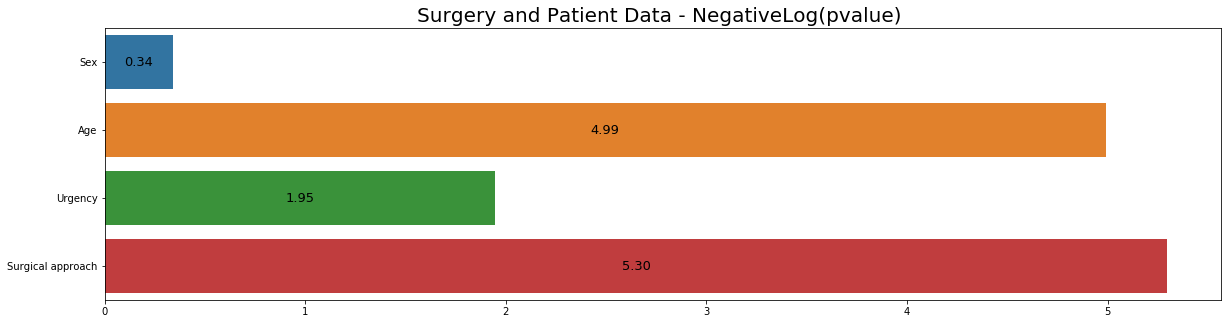

In [139]:
plot_1row(stats_patient_data.iloc[:1,:-1],"Surgery and Patient Data - NegativeLog(pvalue) ",(20,5),'neg log', False, _)

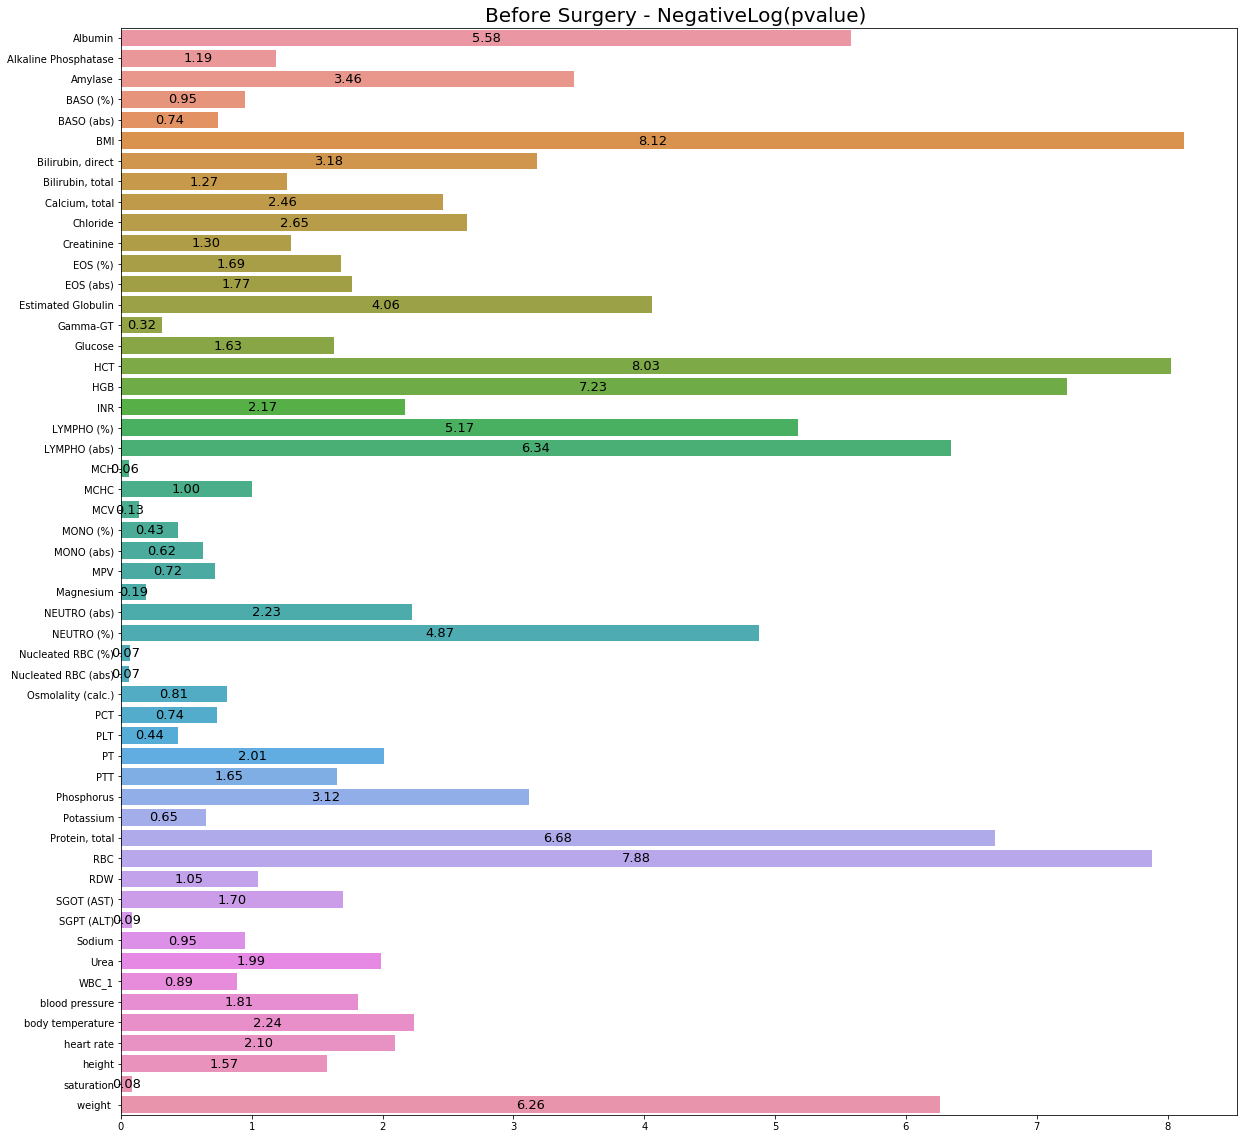

In [140]:
plot_1row(stats_before_surgery_data.iloc[:-1,1:],"Before Surgery - NegativeLog(pvalue) ",(20,20), 'neg log', False,_)

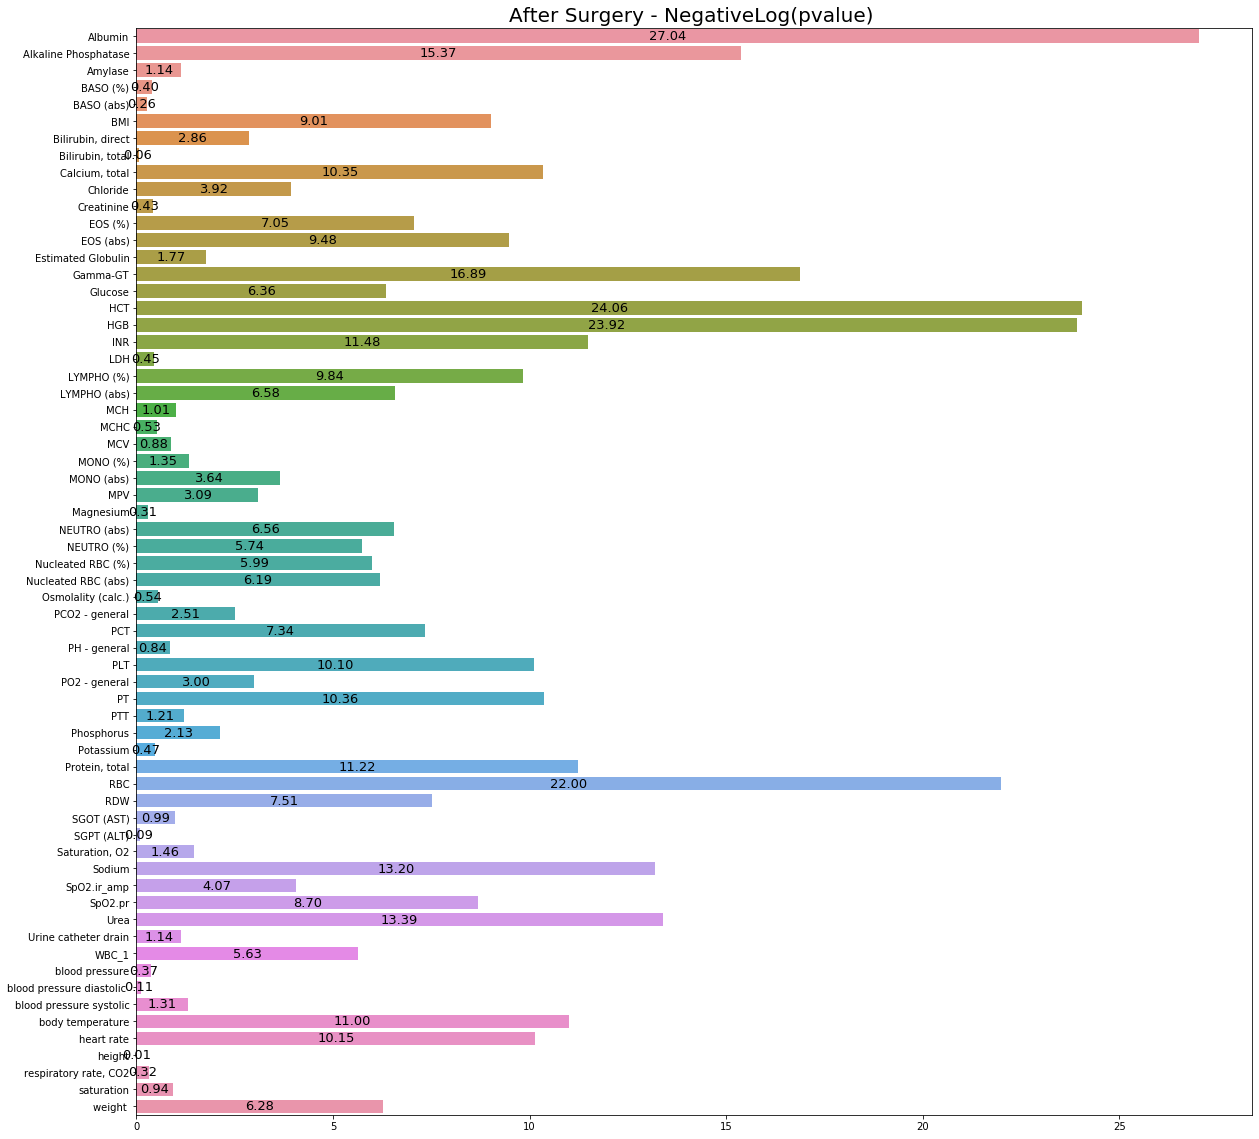

In [142]:
plot_1row(stats_after_surgery_data.iloc[:-1,1:],"After Surgery - NegativeLog(pvalue) ", (20,20),'neg log',False, _)

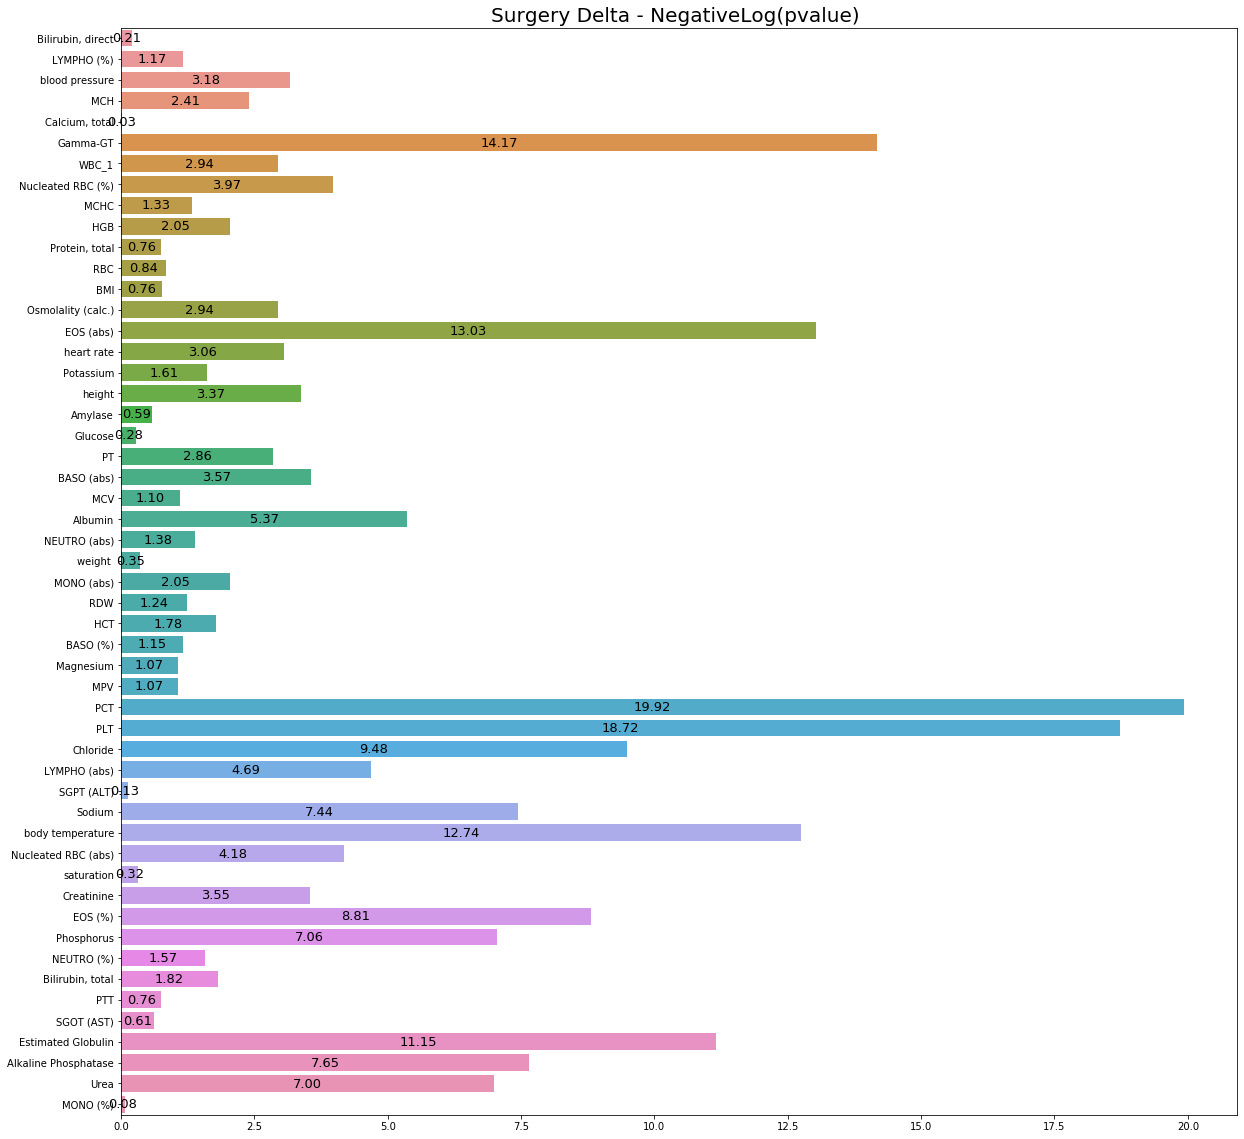

In [143]:
plot_1row(stats_surgery_data_delta.iloc[:-1,1:],"Surgery Delta - NegativeLog(pvalue) ", (20,20),'neg log', False, _)

##### 1.1.2. Disjointification
Ranking the features by the wrs, then take the highest, then take the correlation between the k-th and k-1 and then remove the bottom one if a correlation appears

In [205]:
def get_disjointification_value(df, stats_df):
    # If AL is an included feature, remove it
    if "Anastomotic Leak" in df.columns:
        sorted_df = stats_df.sort_values(by ='p_val', axis=1).drop("Anastomotic Leak",axis = 1)
    else:
        sorted_df = stats_df.sort_values(by ='p_val', axis=1)
    graph = pd.DataFrame(index = ["corr"])
    print(sorted_df.columns)
    # Go over all sorted features 

    for i in range(sorted_df.shape[1]):
        features = [] # Features list will compare the top i features
        # Get the list of higher p-value'd features than the ith features
        print("Comparing: {}: {}".format(i, sorted_df.iloc[:,i].name))
        for j in range(i,-1,-1):
            features.append(sorted_df.iloc[:,j].name)
        # compare their pearsons
        features_to_remove = []
        print("ff",features)
        for comp_feature in features[1:]: # Dont compare the ith feature to itself
            temp = pd.DataFrame((df[features[0]], df[comp_feature])).T
            temp.dropna(axis=0, how = 'any',inplace=True)   
            pearson = stats.pearsonr(temp.iloc[:,0], temp.iloc[:,1])[0]
            graph["{} | {}".format(features[0],comp_feature)] = pearson
            if np.absolute(pearson) > 0.5:
                print("{} | {} - REMOVE".format(features[0],comp_feature),pearson)
                features_to_remove.append(comp_feature)
#             else:
#                 print("{} | {}".format(features[0],comp_feature),pearson)
        sorted_df = sorted_df.drop(features_to_remove, axis=1)
        print(len(sorted_df.columns)) # allows us to check 
        print("--------------------")
#     return graph,len(sorted_df.columns)

In [206]:
dj_before_surgery, feature_num = get_disjointification_value(before_surgery_data, stats_before_surgery_data)
plot_1row(dj_before_surgery,"Disjointification - Before Surgery {}/{} Features ".format(feature_num,len(before_surgery_data.columns)),(20,300),'regular', True, 0.5)

Index(['BMI', 'HCT', 'RBC', 'HGB', 'Protein, total', 'LYMPHO (abs)', 'weight ',
       'Albumin', 'LYMPHO (%)', 'NEUTRO (%)', 'Estimated Globulin', 'Amylase',
       'Bilirubin, direct', 'Phosphorus', 'Chloride', 'Calcium, total',
       'body temperature', 'NEUTRO (abs)', 'INR', 'heart rate', 'PT', 'Urea',
       'blood pressure', 'EOS (abs)', 'SGOT (AST)', 'EOS (%)', 'PTT',
       'Glucose', 'height', 'Creatinine', 'Bilirubin, total',
       'Alkaline Phosphatase', 'RDW', 'MCHC', 'Sodium', 'BASO (%)', 'WBC_1',
       'Osmolality (calc.)', 'BASO (abs)', 'PCT', 'MPV', 'Potassium',
       'MONO (abs)', 'PLT', 'MONO (%)', 'Gamma-GT', 'Magnesium', 'MCV',
       'SGPT (ALT)', 'saturation', 'Nucleated RBC (%)', 'Nucleated RBC (abs)',
       'MCH'],
      dtype='object')
Comparing: 0: BMI
ff ['BMI']
53
--------------------
Comparing: 1: HCT
ff ['HCT', 'BMI']
53
--------------------
Comparing: 2: RBC
ff ['RBC', 'HCT', 'BMI']
RBC | HCT - REMOVE 0.8741512264461252
52
--------------------
Compar

IndexError: single positional indexer is out-of-bounds

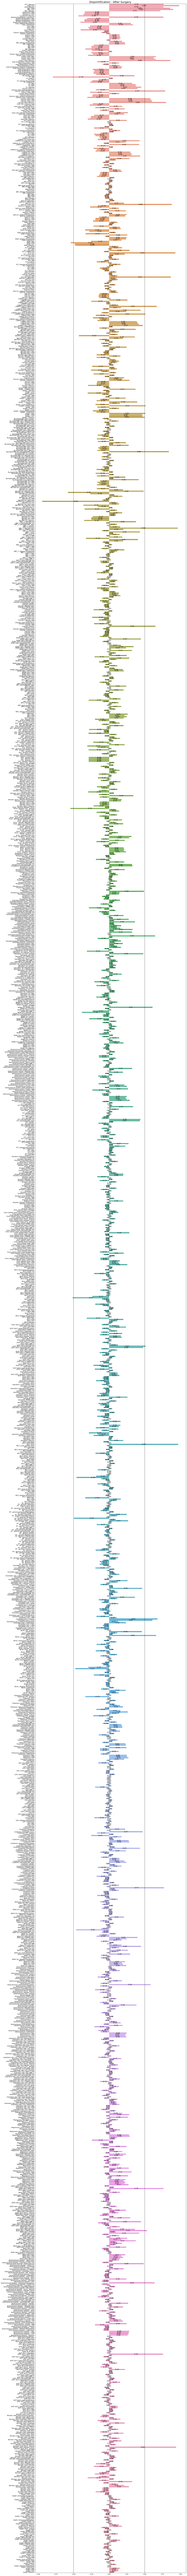

In [130]:
dj_after_surgery, feature_num = get_disjointification_value(after_surgery_data, stats_after_surgery_data)
plot_1row(dj_after_surgery,"Disjointification - After Surgery {}/{} Features ".format(feature_num,len(after_surgery_data.columns)), (20,350),'regular', True, 0.5)

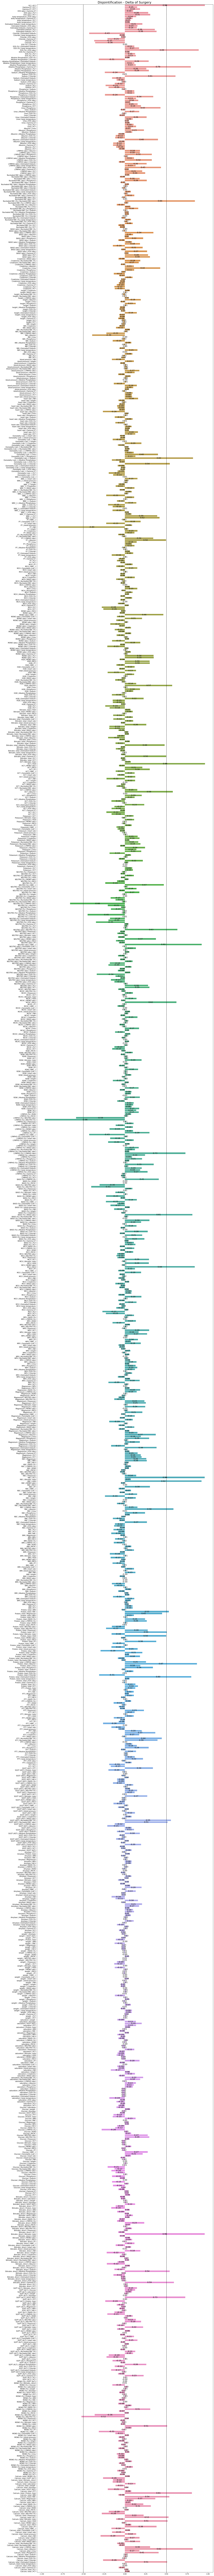

In [131]:
dj_delta_surgery = get_disjointification_value(delta, stats_surgery_data_delta)
plot_1row(dj_delta_surgery,"Disjointification - Delta of Surgery ",(20,300),'regular', True, 0.5)

#### FDR
Apply false discovery rate

https://matthew-brett.github.io/teaching/fdr.html

In [24]:
def get_fdr_plot (df ,title):
    
    p_values = np.sort(df)
    q = 0.05
    N = p_values.size
    i = np.arange(1,N+1) # the 1-based i index of the p values, as in p(i)
    
    plt.figure(figsize=(10,5))
    
    plt.title(title)
    plt.plot(i, p_values,  'b.', label='$p(i)$')
    plt.plot(i, q * i / N, 'r', label='$q i / N$') # the acceptable number of false positives
    plt.xlabel('$i$')
    plt.ylabel('p value')
    plt.legend()
    plt.show()
    return


We are looking for the largest $p(i) < q*i/N$, which corresponds to the last blue point below the red line

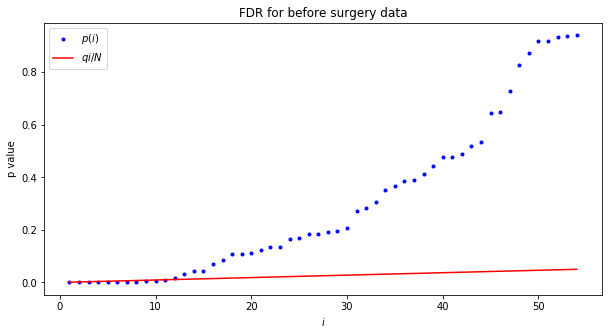

In [25]:
get_fdr_plot(stats_before_surgery_data.iloc[0,:], 'FDR for before surgery data')

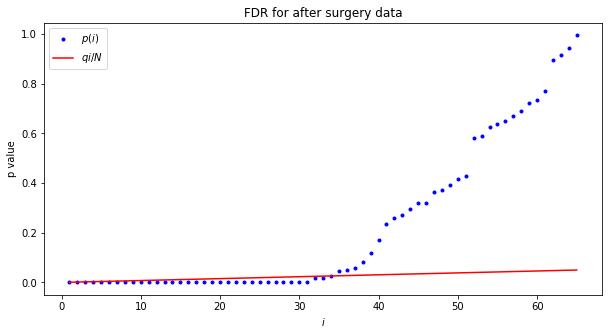

In [26]:
get_fdr_plot(stats_after_surgery_data.iloc[0,:], 'FDR for after surgery data')

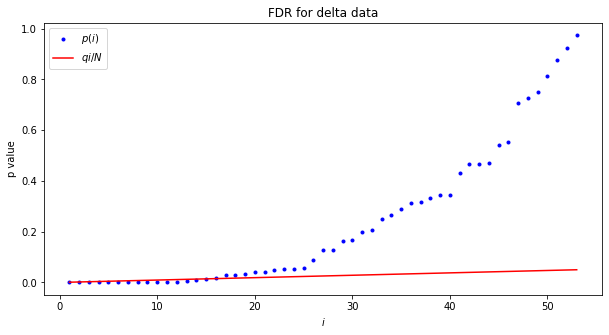

In [27]:
get_fdr_plot(stats_surgery_data_delta.iloc[0,:], 'FDR for delta data')

FDR Fix

In [28]:
# import statsmodels
# from statsmodels.sandbox.stats.multicomp import fdrcorrection0
# ss.multitest.fdrcorrection(stats_before_surgery_data.iloc[0,:].values, alpha=0.05, method='indep', is_sorted=False)

#### 1.1.3. Boxplots for Significant Features

In [29]:
def significant_features(df,title):
#     plt.figure(figsize=(15,10))
    sns.boxplot(x=df.columns[0], y=df.columns[1], data=df)
    sns.swarmplot(x=df.columns[0], y=df.columns[1], data=df, color=".25")
    plt.title(title)
    plt.show()

Patient Data


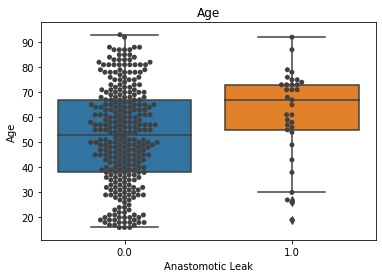

In [30]:
print("Patient Data")
significant_features(patient_data[['Anastomotic Leak', 'Age']],"Age")

In [ ]:
# before_surgery_data[before_surgery_data['BMI']> 60]

Before Surgery


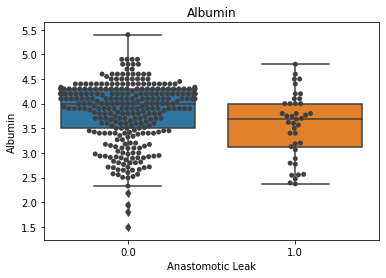

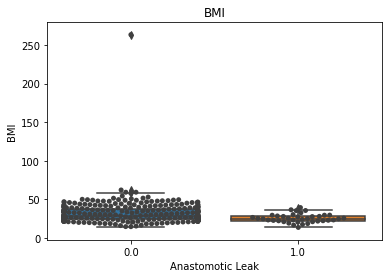

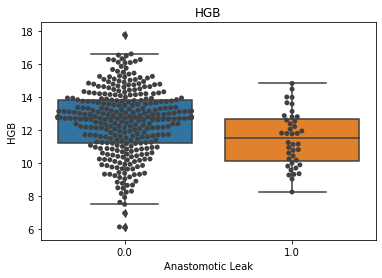

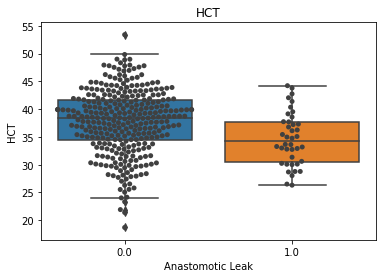

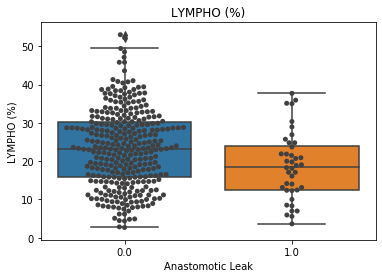

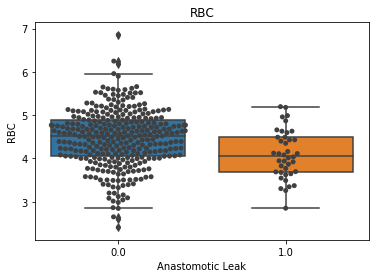

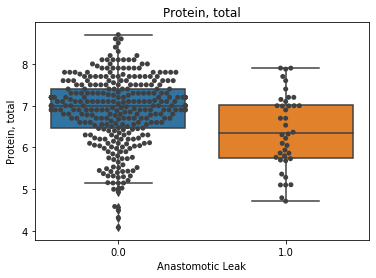

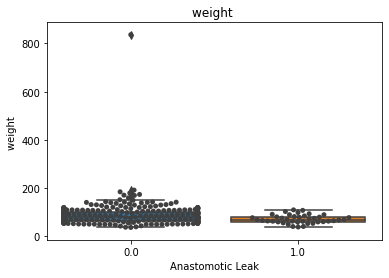

In [31]:
print('Before Surgery')
sigfig_before = ['Albumin', 'BMI', 'HGB', 'HCT', 'LYMPHO (%)', 'RBC', 'Protein, total', 'weight ']
for i in sigfig_before:
    significant_features(before_surgery_data[['Anastomotic Leak', i]],i)

In [32]:
before_surgery_data.columns

Index(['Anastomotic Leak', 'Albumin', 'Alkaline Phosphatase', 'Amylase',
       'BASO (%)', 'BASO (abs)', 'BMI', 'Bilirubin, direct',
       'Bilirubin, total', 'Calcium, total', 'Chloride', 'Creatinine',
       'EOS (%)', 'EOS (abs)', 'Estimated Globulin', 'Gamma-GT', 'Glucose',
       'HCT', 'HGB', 'INR', 'LYMPHO (%)', 'LYMPHO (abs)', 'MCH', 'MCHC', 'MCV',
       'MONO (%)', 'MONO (abs)', 'MPV', 'Magnesium', 'NEUTRO (abs)',
       'NEUTRO (%)', 'Nucleated RBC (%)', 'Nucleated RBC (abs)',
       'Osmolality (calc.)', 'PCT', 'PLT', 'PT', 'PTT', 'Phosphorus',
       'Potassium', 'Protein, total', 'RBC', 'RDW', 'SGOT (AST)', 'SGPT (ALT)',
       'Sodium', 'Urea', 'WBC_1', 'blood pressure', 'body temperature',
       'heart rate', 'height', 'saturation', 'weight '],
      dtype='object')

In [33]:
sigfig_before

['Albumin',
 'BMI',
 'HGB',
 'HCT',
 'LYMPHO (%)',
 'RBC',
 'Protein, total',
 'weight ']

### 1.2.
#### Removing partient that have no events AND target is without AL

In [ ]:
# patient_with_enough_events = full_df.dropna(axis = 0, how = all ,thresh=300)
# patient_with_enough_events.isnull().sum(axis=1)

# RESULT_PATH = 'patient_with_enough_events.xlsx'
# patient_missing_events.to_excel(RESULT_PATH)